<a href="https://colab.research.google.com/github/aysckmk/CEV-Bebka2022/blob/main/SpotifyCapstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [7]:
pip install spotipy --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
# General tools
import os
import datetime

#For data Handling
import pandas as pd
import numpy as np
import spotipy

#For Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
%matplotlib inline

#Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

#Progreebar
from tqdm import tqdm

# For transformations and predictions
from statistics import mean
from scipy.optimize import curve_fit
from yellowbrick.target import FeatureCorrelation
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# For scoring
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score,mean_absolute_error

# For validation
from sklearn.model_selection import train_test_split

In [9]:
DATA_DIR = './data'

In [12]:
df = pd.read_csv('/content/DATA_DIR/data.csv')

# Dataset Descriptions 

In [13]:
df.head(10)
df.describe()

,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
count,170653.000000,170653.000000,170653.000000,170653.000000,1.706530e+05,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000
mean,0.528587,1976.787241,0.502115,0.537396,2.309483e+05,0.482389,0.084575,0.167010,5.199844,0.205839,-11.467990,0.706902,31.431794,0.098393,116.861590
std,0.263171,25.917853,0.376032,0.176138,1.261184e+05,0.267646,0.278249,0.313475,3.515094,0.174805,5.697943,0.455184,21.826615,0.162740,30.708533
min,0.000000,1921.000000,0.000000,0.000000,5.108000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000
25%,0.317000,1956.000000,0.102000,0.415000,1.698270e+05,0.255000,0.000000,0.000000,2.000000,0.098800,-14.615000,0.000000,11.000000,0.034900,93.421000
50%,0.540000,1977.000000,0.516000,0.548000,2.074670e+05,0.471000,0.000000,0.000216,5.000000,0.136000,-10.580000,1.000000,33.000000,0.045000,114.729000
75%,0.747000,1999.000000,0.893000,0.668000,2.624000e+05,0.703000,0.000000,0.102000,8.000000,0.261000,-7.183000,1.000000,48.000000,0.075600,135.537000
max,1.000000,2020.000000,0.996000,0.988000,5.403500e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.970000,243.507000


# EDA

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [15]:
df['duration_min'] = df['duration_ms']/60000
df['duration_min'] = df['duration_min'].round(2)
df['duration_min'].head()

0    13.86
1     3.01
2     8.33
3     3.50
4     2.78
Name: duration_min, dtype: float64

In [16]:
df["artists"]=df["artists"].str.replace("[", "")
df["artists"]=df["artists"].str.replace("]", "")
df["artists"]=df["artists"].str.replace("'", "")

df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,duration_min
0,0.0594,1921,0.982,"Sergei Rachmaninoff, James Levine, Berliner Ph...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954,13.86
1,0.9630,1921,0.732,Dennis Day,0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,3.01
2,0.0394,1921,0.961,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339,8.33
3,0.1650,1921,0.967,Frank Parker,0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109,3.50
4,0.2530,1921,0.957,Phil Regan,0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,2.78


In [17]:
df.duplicated().any().sum()

0

In [18]:
df[(df['artists'] == "Billie Holiday") & (df['name']== "No Regrets - Take 1")]

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,duration_min
2293,0.77,1933,0.93,Billie Holiday,0.721,155667,0.186,0,65YsrE85spoEzDa3O8iCPT,0.000145,3,0.351,-13.833,1,No Regrets - Take 1,17,1933,0.0458,129.452,2.59
2298,0.77,1933,0.93,Billie Holiday,0.721,155667,0.186,0,4FU5KzT1MaIuIV4thAY870,0.000145,3,0.351,-13.833,1,No Regrets - Take 1,17,1933,0.0458,129.452,2.59


Observation - There are not any duplicates in the data set because of the unique id feature.Let's see if we remove this are there any duplicates

In [19]:
df = df.drop(labels=['id', 'release_date'], axis=1)
df.shape

(170653, 18)

In [20]:
df.duplicated().sum()

565

In [21]:
df = df[~df.duplicated()==1]
df.shape

(170088, 18)

In [22]:
df.duplicated().sum()

0

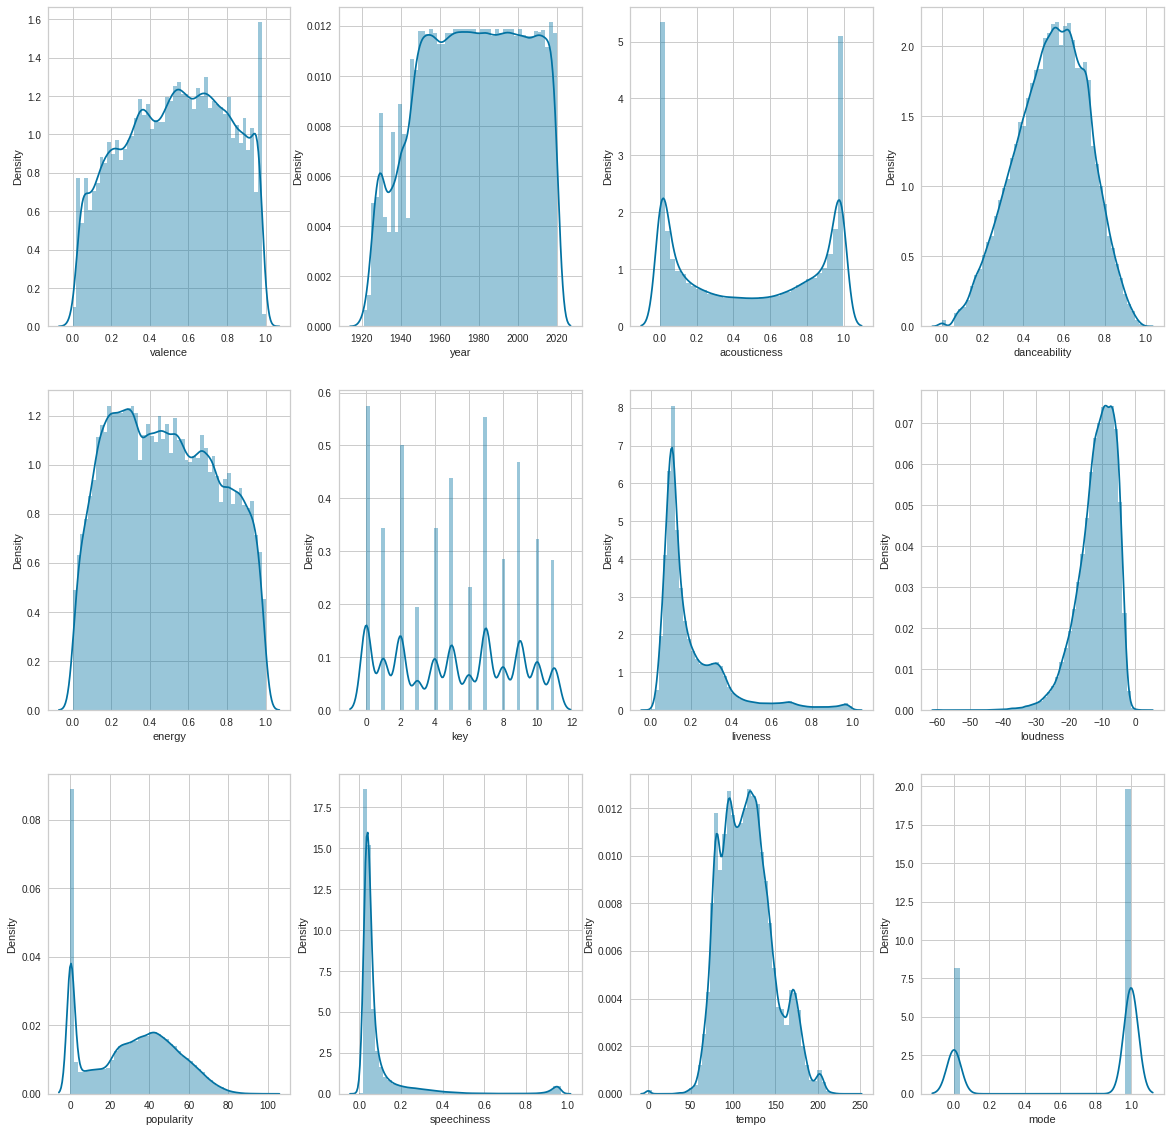

In [23]:
plt.rcParams.update({'font.size': 22})
#Visualisation of Variability for each column in the dataframe
fig,ax = plt.subplots(3,4,figsize=(20,20))

sns.distplot(df['valence'],ax=ax[0,0])
sns.distplot(df['year'],ax=ax[0,1])
sns.distplot(df['acousticness'],ax=ax[0,2])
sns.distplot(df['danceability'],ax=ax[0,3])
#sns.distplot(df['duration_min'],ax=ax[1,1])
sns.distplot(df['energy'],ax=ax[1,0])
sns.distplot(df['key'],ax=ax[1,1])
sns.distplot(df['liveness'],ax=ax[1,2])
sns.distplot(df['loudness'],ax=ax[1,3])
sns.distplot(df['popularity'],ax=ax[2,0])
sns.distplot(df['speechiness'],ax=ax[2,1])
sns.distplot(df['tempo'],ax=ax[2,2])
sns.distplot(df['mode'],ax=ax[2,3])

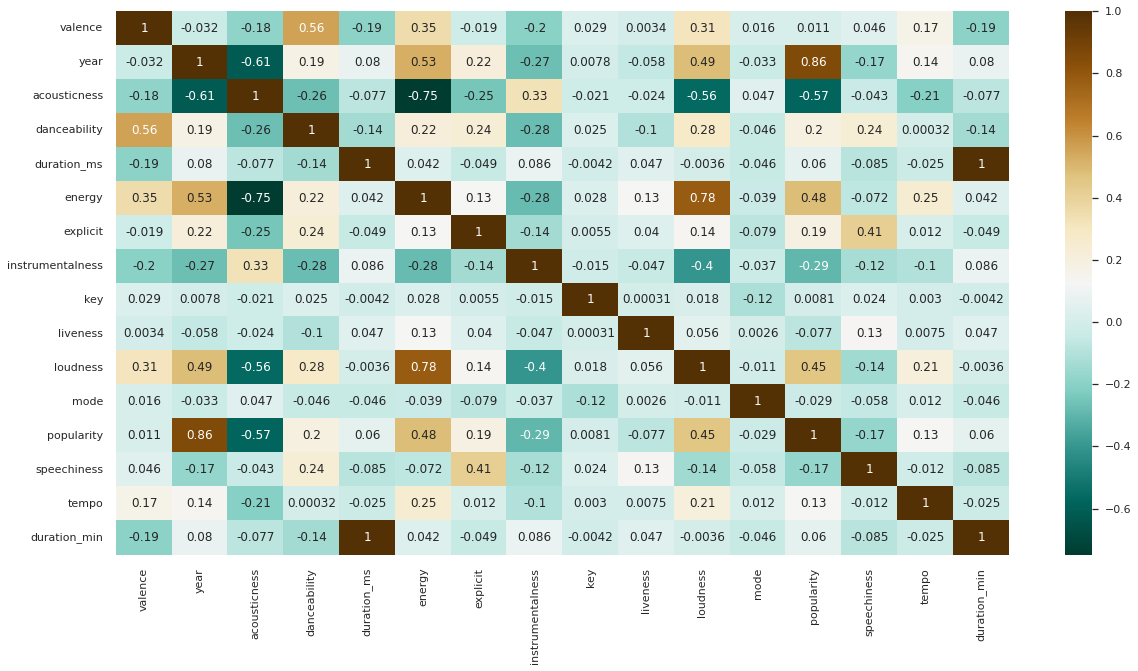

In [24]:
plt.figure(figsize=(20,10))
sns.set(style="whitegrid")
corr = df.corr()
sns.heatmap(corr,annot=True,cmap='BrBG_r',annot_kws={"fontsize":12})

(array([  0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 7 Text major ticklabel objects>)

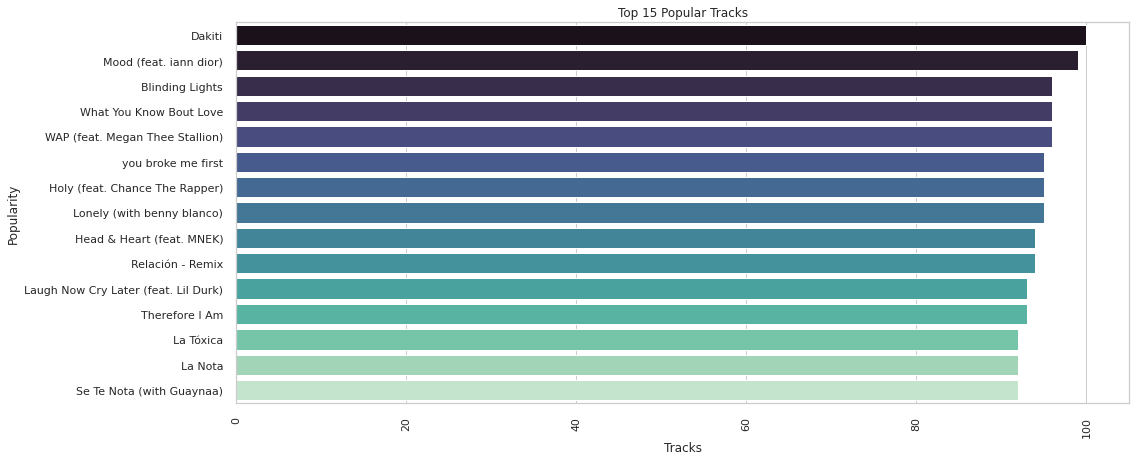

In [25]:
#Most Popular Tracks
fig, axis = plt.subplots(figsize = (16,7))
popular = df.groupby("name")['popularity'].mean().sort_values(ascending=False).head(15)
axis = sns.barplot(popular,popular.index,palette="mako",orient = 'h')
axis.set_title('Top 15 Popular Tracks')
axis.set_ylabel('Popularity')
axis.set_xlabel('Tracks')
plt.xticks(rotation = 90)

In [26]:
df.groupby("name")['popularity'].mean().sort_values(ascending=False).head(15)

name
Dakiti                                  100.0
Mood (feat. iann dior)                   99.0
Blinding Lights                          96.0
What You Know Bout Love                  96.0
WAP (feat. Megan Thee Stallion)          96.0
you broke me first                       95.0
Holy (feat. Chance The Rapper)           95.0
Lonely (with benny blanco)               95.0
Head & Heart (feat. MNEK)                94.0
Relación - Remix                         94.0
Laugh Now Cry Later (feat. Lil Durk)     93.0
Therefore I Am                           93.0
La Tóxica                                92.0
La Nota                                  92.0
Se Te Nota (with Guaynaa)                92.0
Name: popularity, dtype: float64

(array([    0.,  2500.,  5000.,  7500., 10000., 12500., 15000., 17500.,
        20000., 22500.]), <a list of 10 Text major ticklabel objects>)

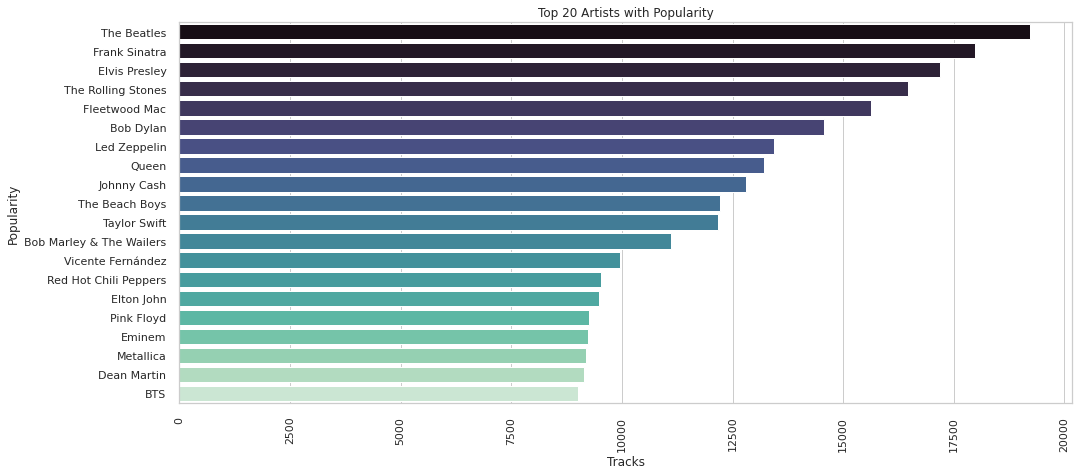

In [27]:
#Most Popular Artists
fig, axis = plt.subplots(figsize = (16,7))
popular = df.groupby("artists")['popularity'].sum().sort_values(ascending=False)[:20]
axis = sns.barplot(popular,popular.index,palette="mako",orient = 'h')
axis.set_title('Top 20 Artists with Popularity')
axis.set_ylabel('Popularity')
axis.set_xlabel('Tracks')
plt.xticks(rotation = 90)

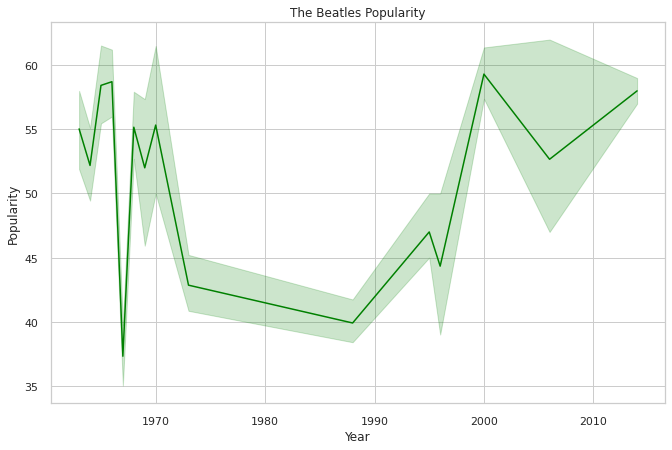

In [28]:
# visualize the popularity of The Beatles songs over the year
Beatles = df[df['artists'] == 'The Beatles']
plt.rcParams['figure.figsize'] = (11,7)
# line plot passing x,y
sns.lineplot(x='year', y='popularity', data=Beatles, color='green')
# Labels
plt.title("The Beatles Popularity")
plt.xlabel('Year')
plt.ylabel('Popularity')
plt.show()

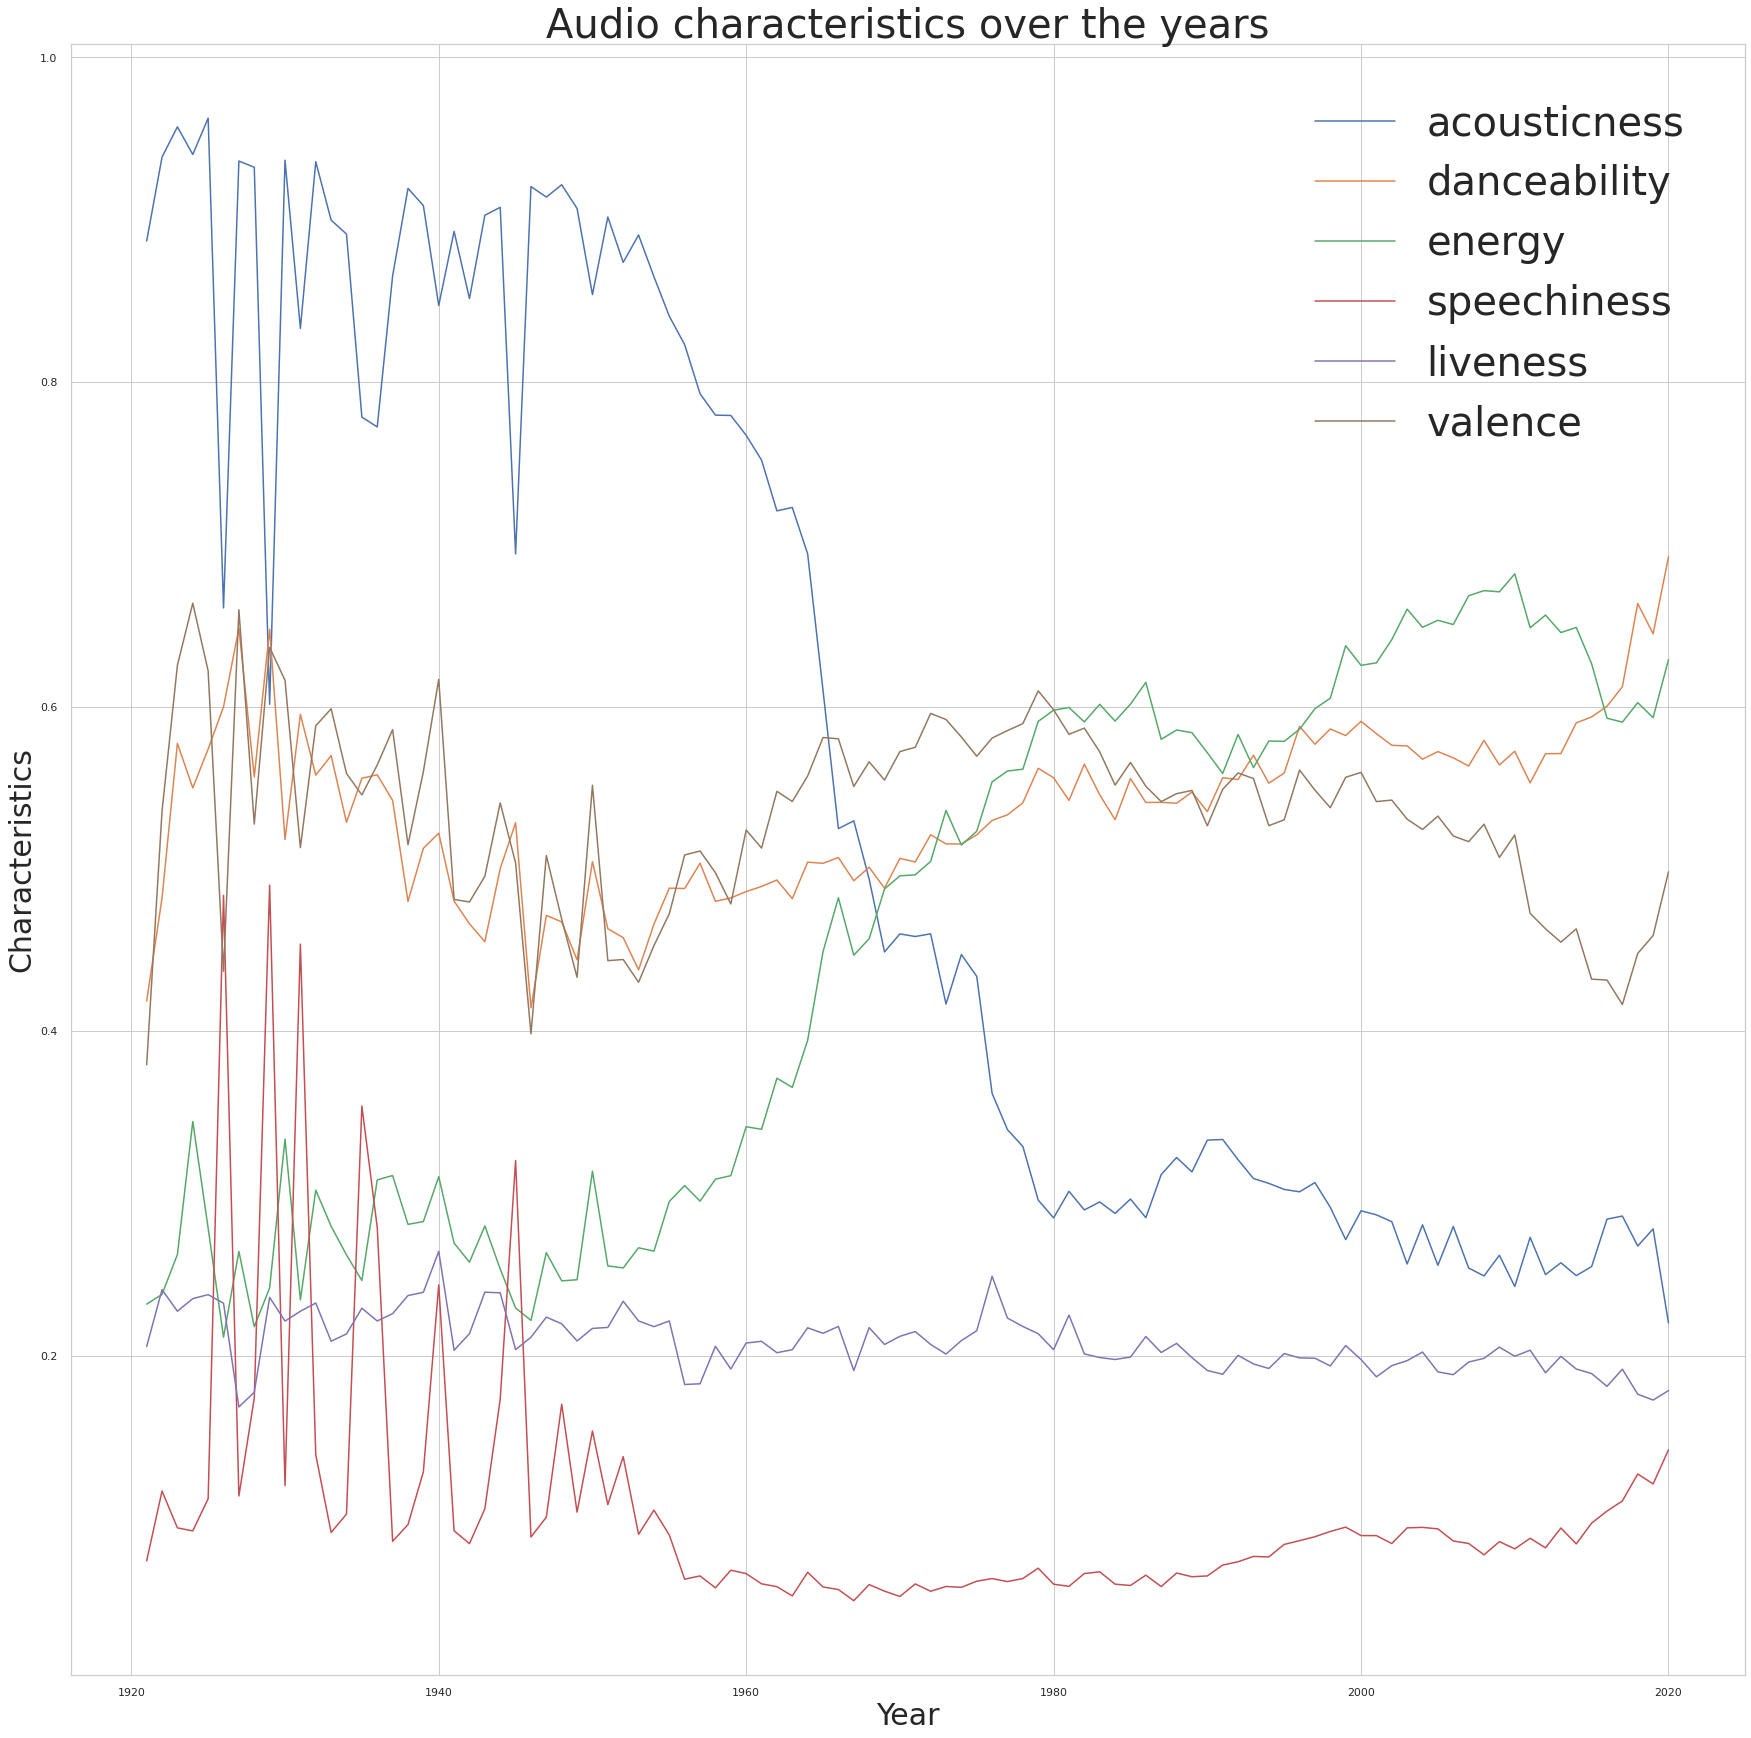

In [29]:
columns = ["acousticness","danceability","energy","speechiness","liveness","valence"]
plt.figure(figsize=(30,30))
for c in columns:
    x = df.groupby('year')[c].mean()
    sns.lineplot(x.index,x,label=c)
plt.title('Audio characteristics over the years', fontsize=40)
plt.xlabel('Year',fontsize=30)
plt.ylabel('Characteristics',fontsize=30)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 40}, loc = 'upper right')
plt.show()

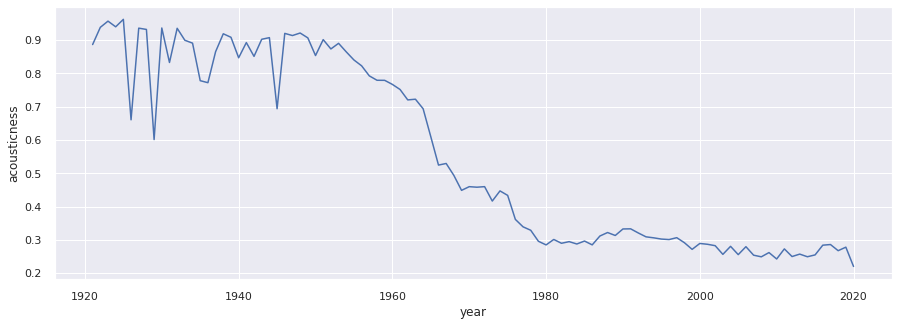

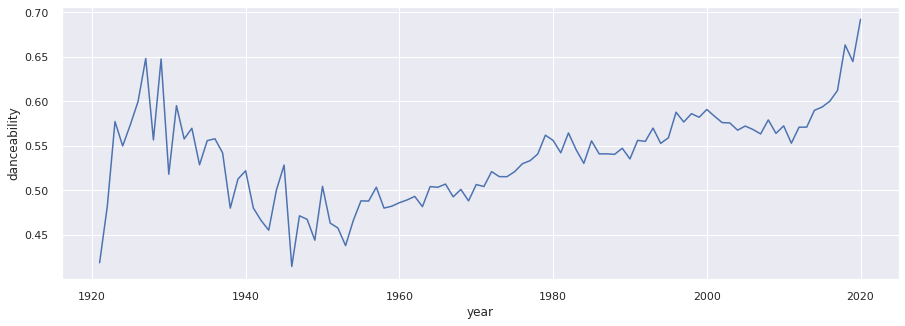

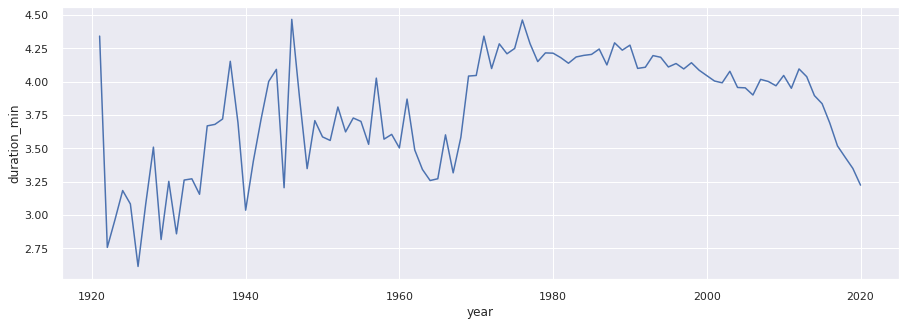

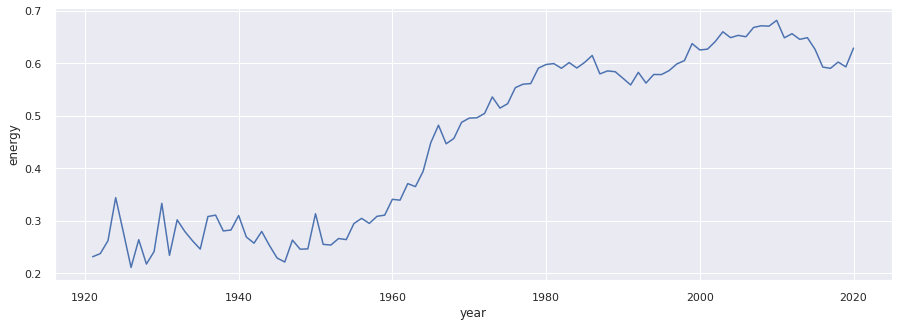

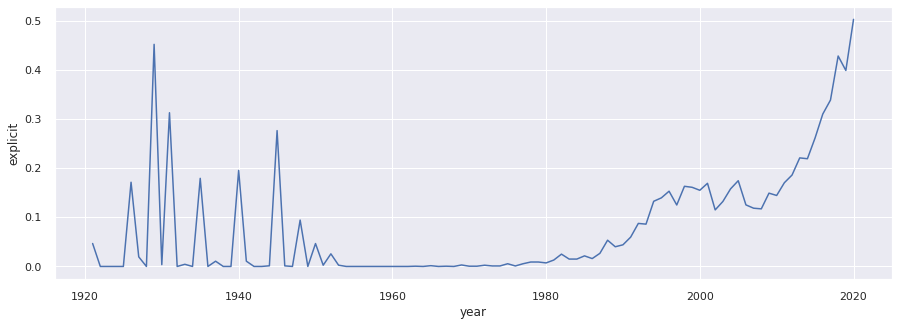

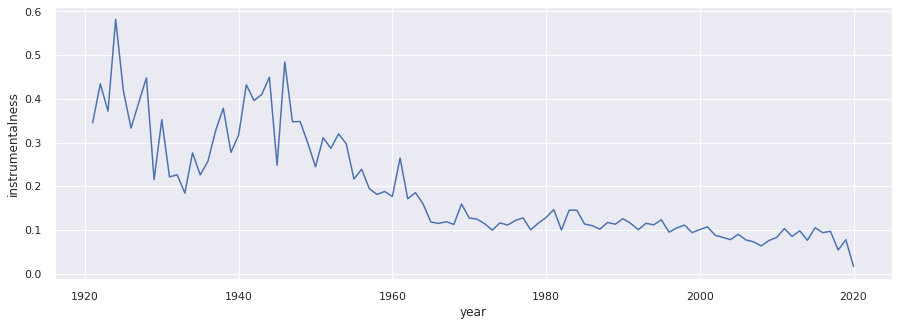

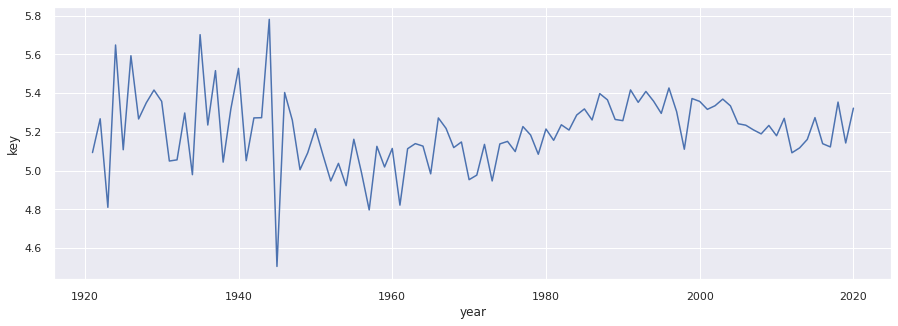

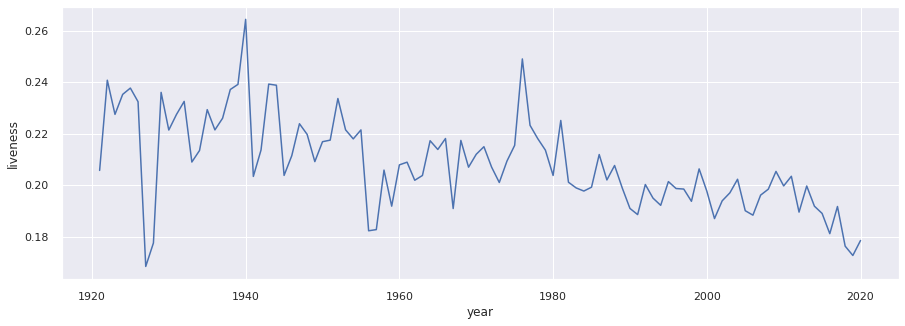

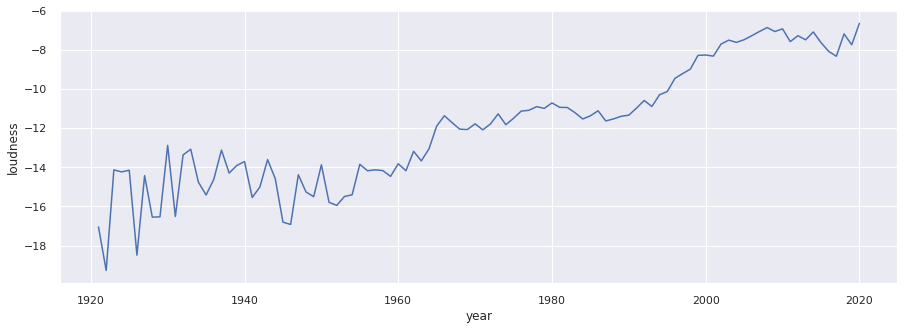

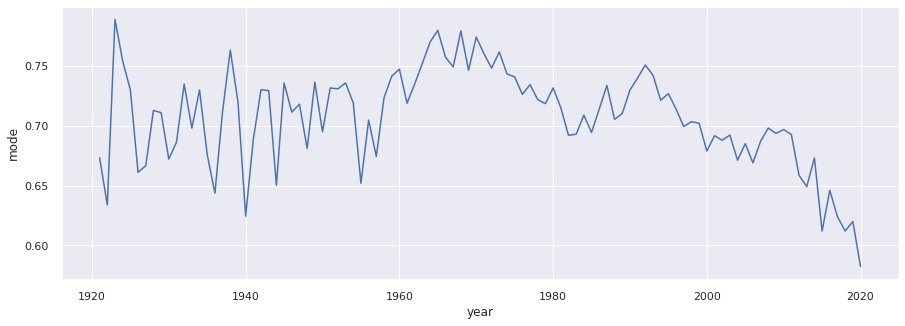

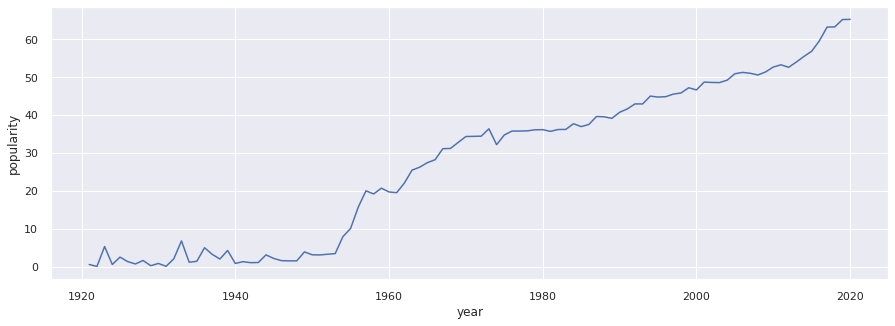

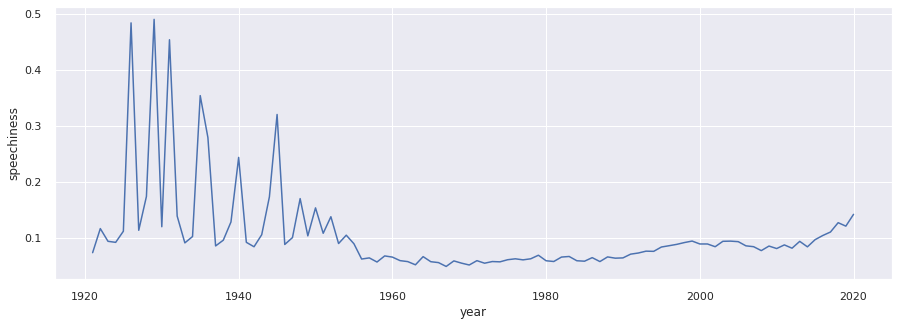

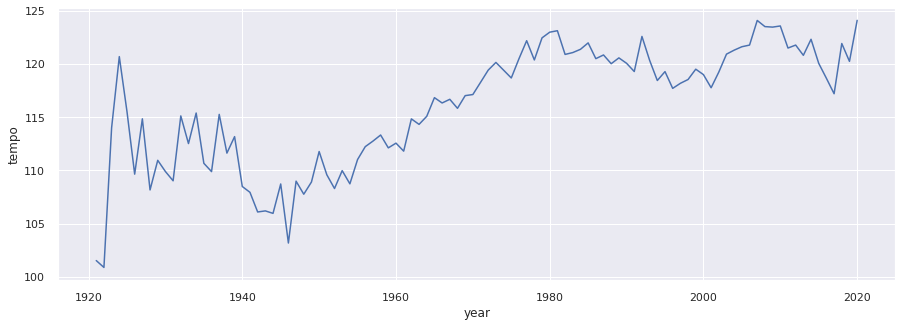

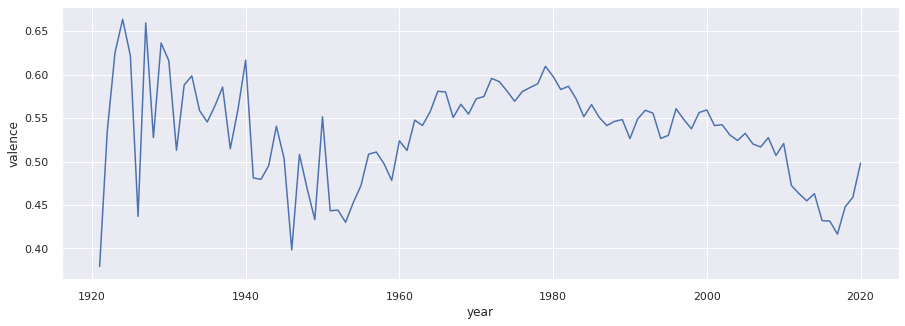

In [30]:
columns = ['acousticness','danceability', 'duration_min', 'energy', 'explicit',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'popularity', 'speechiness', 'tempo', 'valence']
for col in columns:
    y = df.groupby('year')[col].mean()
    x = y.index
    plt.figure(figsize=(15, 5))
    sns.set_style("darkgrid")
    sns.lineplot(x, y)

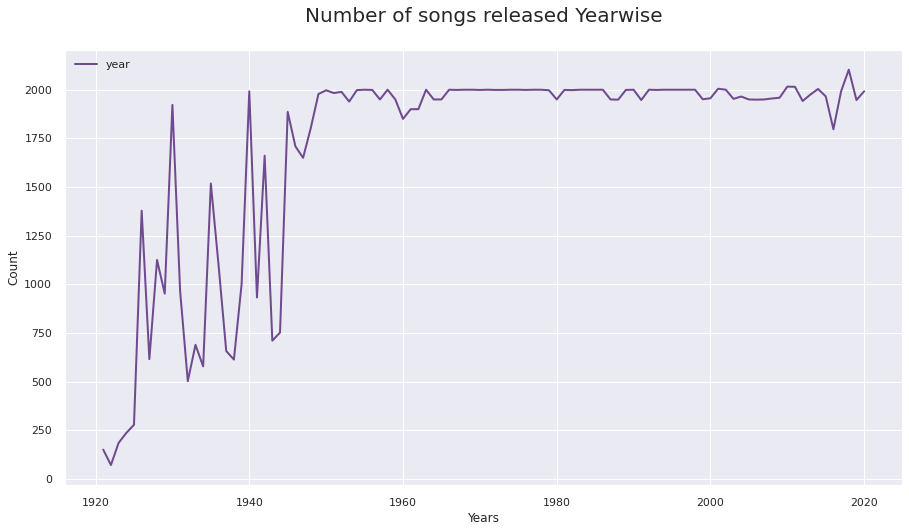

In [31]:
year = pd.DataFrame(df['year'].value_counts())
year = year.sort_index()
ax=year.plot(kind='line',figsize=(15,8) ,color='#6f4a8e', linewidth=2)
plt.title("Number of songs released Yearwise",y=1.05,fontsize=20)
plt.xlabel('Years')
plt.ylabel('Count')
ax.axes.get_xaxis().set_visible(True)

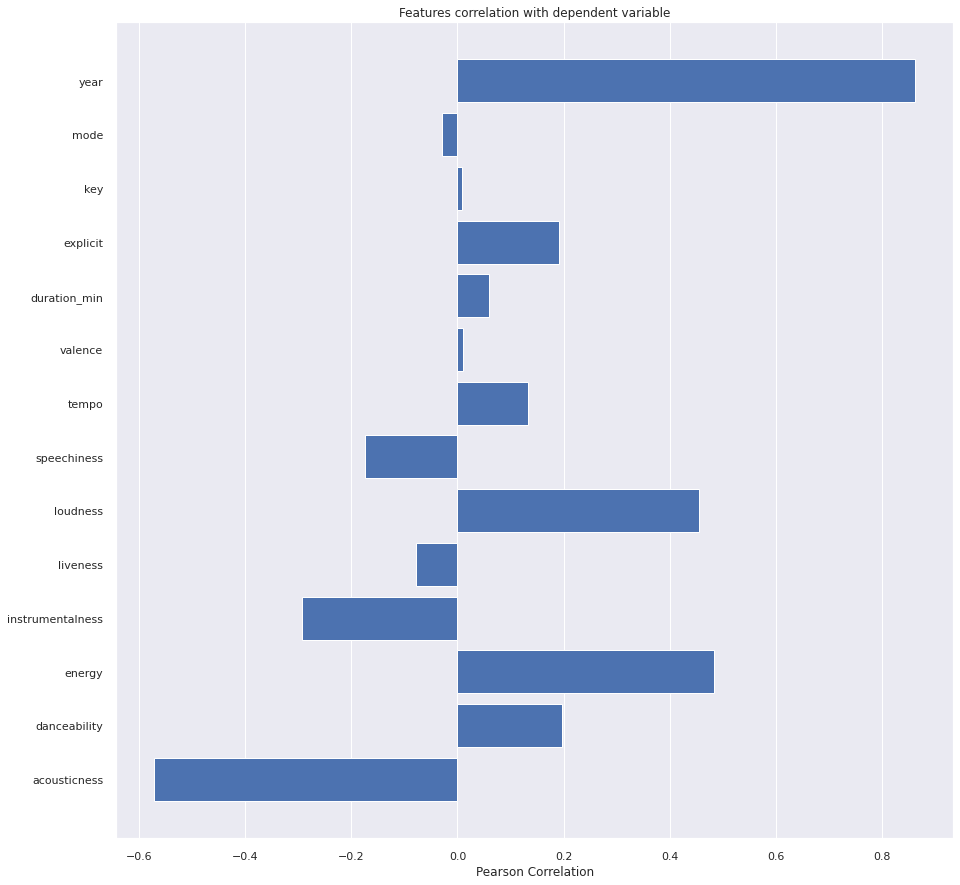

In [32]:
feature_names = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_min','explicit','key','mode','year']

X, y = df[feature_names], df['popularity']

# Create a list of the feature names

features = np.array(feature_names)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(15,15)
visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()  

# Pre Processing

In [33]:
num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num = df.select_dtypes(include=num_types)

In [34]:
scaler = MinMaxScaler()
num = scaler.fit_transform(num)

In [35]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8).fit(num)
df['pred'] = kmeans.fit_predict(num)

num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num = df.select_dtypes(include=num_types)
scaler = MinMaxScaler()
num = scaler.fit_transform(num)

In [36]:
from scipy import spatial

def get_recommendations(df, song_name, n_top):
    columns = df.select_dtypes(include=num_types).columns
    distances = []
    #choosing the given song_name and dropping it from the data
    song = df[(df.name.str.lower() == song_name.lower())].head(1)
    rem_data = df[df.name.str.lower() != song_name.lower()]
    for index, r_song in tqdm(rem_data.iterrows(), total=rem_data.shape[0]):
        r_list = r_song[columns].values.flatten().tolist()
        s_list = song[columns].values.flatten().tolist()
        dist = spatial.distance.cosine(r_list, s_list)
        distances.append(dist)
    rem_data['distance'] = distances
    #sorting our data to be ascending by 'distance' feature
    rem_data = rem_data.sort_values('distance')
    columns = ['artists', 'name']
    return rem_data[columns][:n_top]

In [37]:
get_recommendations(df, 'Black Metal', 20)

100%|██████████| 170087/170087 [01:55<00:00, 1470.76it/s]


,artists,name
13709,Keith Whitley,When You Say Nothing at All
123560,Lincoln Brewster,There Is Power
73154,Drake,The Resistance
169532,Daniel Caesar,Little Rowboat
55802,Kolton Moore & the Clever Few,Dear Mom
88986,Alan Silvestri,Seeing Is Believing
9391,Jimi Hendrix,Burning of the Midnight Lamp
55328,Lenny Cooper,Mud Digger Remix (feat. Colt Ford)
130782,Lucio Battisti,Mi ritorni in mente
28350,The Meters,Stormy


In [38]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd

# Spotify API yetkilendirme bilgileri
client_id = 'b863d74144ac488a8ae17d755cd14548'
client_secret = '8a3ee56f9cc04f09a563e7ed72618344'
redirect_uri = 'your_redirect_uri'

# Yetkilendirme işlemi
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Çalma listesi ID'si
playlist_id = '0akDfyCydrG9Pj8EKlyogh'

# Çalma listesi şarkılarını alma
results = sp.playlist_items(playlist_id=playlist_id, fields='items(track(name, artists(name)))')

# Şarkı adları ve sanatçılarını içeren bir liste oluşturma
songs = []
for item in results['items']:
    track = item['track']
    song_name = track['name']
    artist_names = [artist['name'] for artist in track['artists']]
    songs.append((song_name, artist_names))

# Liste verilerini bir dataframe'e dönüştürme
playlist_df = pd.DataFrame(songs, columns=['Song Name', 'Artist Names'])


In [39]:
playlist_df

,Song Name,Artist Names
0,Criminal,[Britney Spears]
1,Bu Havada Gidilmez,[Manuş Baba]
2,Bana Sor (Canlı),"[Cihan Mürtezaoğlu, Ceylan Ertem]"
3,Keklik Gibi,[Melek Mosso]
4,Tutuşmuş Beraber,[Melike Şahin]
...,...,...
95,Ankara'yla Bozuşuruz,[Perdenin Ardındakiler]
96,Tutuşmuş Beraber - Vp Remix,"[Melike Şahin, Virtupollo]"
97,Hatıralarım,[Perdenin Ardındakiler]
98,Sevsem,[Kahraman Deniz]


In [40]:
playlist_df["Artist Names"]=playlist_df["Artist Names"].astype(str).str.replace("[", "")
playlist_df["Artist Names"]=playlist_df["Artist Names"].astype(str).str.replace("]", "")
playlist_df["Artist Names"]=playlist_df["Artist Names"].astype(str).str.replace("'", "")

In [41]:
playlist_df

,Song Name,Artist Names
0,Criminal,Britney Spears
1,Bu Havada Gidilmez,Manuş Baba
2,Bana Sor (Canlı),"Cihan Mürtezaoğlu, Ceylan Ertem"
3,Keklik Gibi,Melek Mosso
4,Tutuşmuş Beraber,Melike Şahin
...,...,...
95,Ankara'yla Bozuşuruz,Perdenin Ardındakiler
96,Tutuşmuş Beraber - Vp Remix,"Melike Şahin, Virtupollo"
97,Hatıralarım,Perdenin Ardındakiler
98,Sevsem,Kahraman Deniz


In [42]:
def song_recommendation_by_optimal_song(play_df, n_top):
    empty_df = pd.DataFrame()
    for index, row in play_df.iterrows():
        song = df[(df['artists'] == row['Artist Names']) & (df['name'] == row['Song Name'])]
        if not song.empty:
            frames = [empty_df, song]
            empty_df = pd.concat(frames)
    
    columns = empty_df.select_dtypes(include=num_types).columns
    
    song_tuple = []
    
    for index, r_song in tqdm(empty_df.iterrows(), total=empty_df.shape[0]):
        r_list = r_song[columns].values.flatten().tolist()
        
        filtered_df = df[(df['artists'] != r_song['artists']) & (df['name'] != r_song['name'])]
        
        distances = []
        dist = 0
        
        for i, filtered in filtered_df.iterrows():
            s_list = filtered[columns].values.flatten().tolist()
            dist = spatial.distance.cosine(r_list, s_list)
            distances.append(dist)
            
        song_tuple.append((r_song, mean(distances)))
            
    print('Optimal song is ' + min(song_tuple, key = lambda t: t[1])[0]['name'] + 'from ' + min(song_tuple, key = lambda t: t[1])[0]['artists'])
    display(get_recommendations(df, min(song_tuple, key = lambda t: t[1])[0]['name'], n_top))

In [43]:
song_recommendation_by_optimal_song(playlist_df, 20)

100%|██████████| 7/7 [05:27<00:00, 46.85s/it]


Optimal song is Humanfrom "RagnBone Man"


100%|██████████| 170082/170082 [02:00<00:00, 1407.22it/s]


,artists,name
38527,Brent Faiyaz,Dead Man Walking
170587,Little Big Town,Next To You
19389,"Lil Baby, Gunna, Lil Uzi Vert",Life Goes On
12430,Bryan Adams,Heaven
18011,Chief Keef,Love Sosa
12671,George Benson,Nothing's Gonna Change My Love for You
18847,A Boogie Wit da Hoodie,Still Think About You
108862,Carin Leon,Tú
56204,Grimes,Kill V. Maim
38295,"Logic, Eminem",Homicide (feat. Eminem)
